# Mathematics

In [1]:
import torch
import torch.nn as nn

import numpy as np
import scipy.stats as stats

import plotly.graph_objects as go
from plotly.io import renderers
renderers.default = 'png'
from plotly.subplots import make_subplots

from pprint import pprint
from utils.design import plotly_main_layout, plotly_main_subplot_layout

___
### Artificial Neural Network

> #### ANNs
> - $\hat{y}=\sigma(x_0 w_0 + \sum_{i=1}^m x_iw_i)$
> - $\hat{y}=\sigma(\textbf{x}^\text{T}\textbf{w}+w_0)$
> - $\hat{y}=\sigma(\textbf{x}^\text{T}\textbf{w})$
>   - $\sigma$: activation function
>   - $\textbf{x}$: input vector
>   - $\textbf{w}$: weights
>   - $w$: bias (intercept)

> #### Loss Function
> - $\mathcal{L}_\text{MSE}= \dfrac{1}{2}(\hat{y}-y)^2$
> - $\mathcal{L}_\text{Cross-Entropy}= -(y\log (\hat{y}) + (1-y)\log (1-\hat{y}))$

> #### Cost Function
> - $\mathcal{J} = \dfrac{1}{n}\sum_{i=1}^n \mathcal{L}(\hat{y}_i , y_i)$

> #### Backpropagation
> - $\mathbf{w} \leftarrow \mathbf{w} - \eta \partial \mathcal{L}$
> - $\dfrac{\partial \mathcal{L} (\hat{y},y)}{\partial \textbf{w}} = \dfrac{\partial \mathcal{L} (\sigma(\textbf{x}^\text{T}\textbf{w}),y)}{\partial \textbf{w}}$
>   - $\eta$: learning rate 
>   - $\partial \mathcal{L}$: derivative of loss

___
### Simple Regression

- $y_i = \beta_0 + \beta_1x_1 + \epsilon_1$

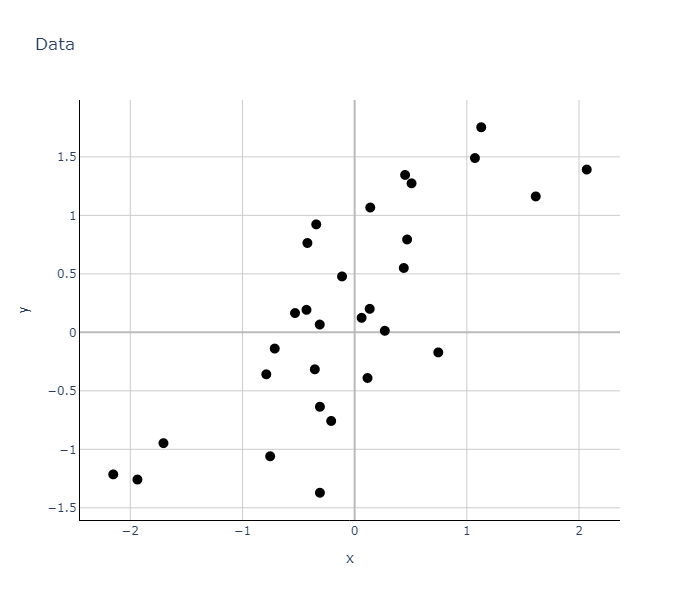

In [2]:
N = 30
x = torch.randn(N, 1)
y = x + torch.randn(N, 1)/2

main_fig = go.Figure()
main_fig.add_trace(go.Scatter(
    x=x.squeeze(), y=y.squeeze(), marker=dict(color='black', size=10),
    mode='markers', name='data'
))
plotly_main_layout(main_fig, title='Data')

In [3]:
ANNreg = nn.Sequential(
    nn.Linear(1,1),  # linear model
                     # in_features=1,out_features=1, bias=True
    # nn.ReLU(),       # Activation function (not needed)
    nn.Linear(1,1)   # Output layer
)

learningRate = 0.05
lossfun = nn.MSELoss()
optimizer = torch.optim.SGD(ANNreg.parameters(), lr=learningRate)

numepochs = 500
losses = torch.zeros(numepochs)

for epoch_i in range(numepochs):
    yHat = ANNreg(x)         # Forward prop

    loss = lossfun(yHat, y)  # Stores loss
    losses[epoch_i] = loss   

    optimizer.zero_grad()    # Backpropagation
    loss.backward()
    optimizer.step()         

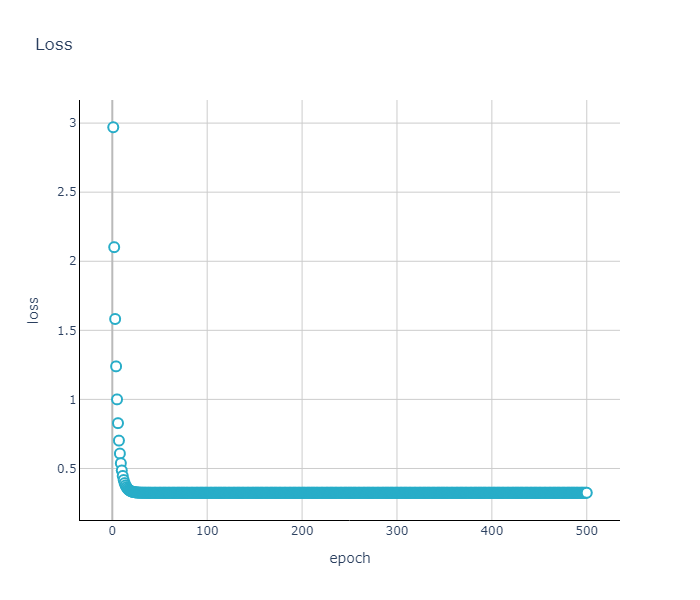

In [9]:
predictions = ANNreg(x)

testloss = (predictions-y).pow(2).mean()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=losses.detach(), 
    name='loss', mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
))
plotly_main_layout(fig, x='epoch', y='loss', title='Loss')

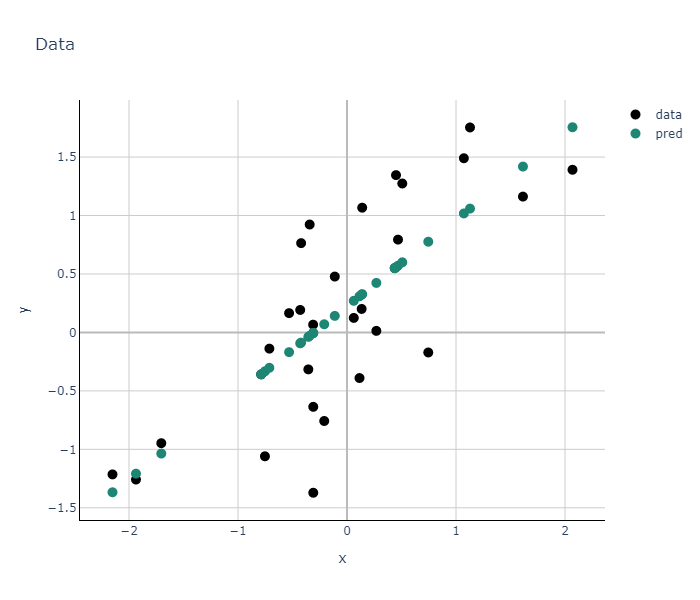

In [5]:
main_fig.add_trace(go.Scatter(
    x=x.squeeze(), y=predictions.squeeze().detach(), mode='markers',
    marker=dict(color='#1d8674', size=10), name='pred'
))

___
### Manipulate Regression Slopes

In [ ]:
def buildAndTrainTheModel(x,y):
    ANNreg = nn.Sequential(
        nn.Linear(1,1),  # linear model
        nn.Linear(1,1)   # Output layer
    )

    lossfun = nn.MSELoss()
    optimizer = torch.optim.SGD(ANNreg.parameters(), lr=0.05)

    numepochs = 500
    losses = torch.zeros(numepochs)

    for epoch_i in range(numepochs):
        yHat = ANNreg(x)         # Forward prop

        loss = lossfun(yHat, y)  # Stores loss
        losses[epoch_i] = loss   

        optimizer.zero_grad()    # Backpropagation
        loss.backward()
        optimizer.step()      

    predictions = ANNreg(x)

    return predictions.squeeze(), losses


def createTheData(m):
    N = 50
    x = torch.randn(N,1)
    y = m*x + torch.randn(N,1)/2
    return x, y

In [ ]:
slopes = np.linspace(-2,2,21)

numExps = 50

results = np.zeros((len(slopes),numExps,2))

for slopei in range(len(slopes)):

  for N in range(numExps):

    # create a dataset and run the model
    x,y = createTheData(slopes[slopei])
    yHat,losses = buildAndTrainTheModel(x,y)
    yHat = yHat.detach()

    # store the final loss and performance
    results[slopei,N,0] = losses[-1]
    results[slopei,N,1] = np.corrcoef(y.T,yHat.T)[0,1]


# correlation can be 0 if the model didn't do well. Set nan's->0
results[np.isnan(results)] = 0

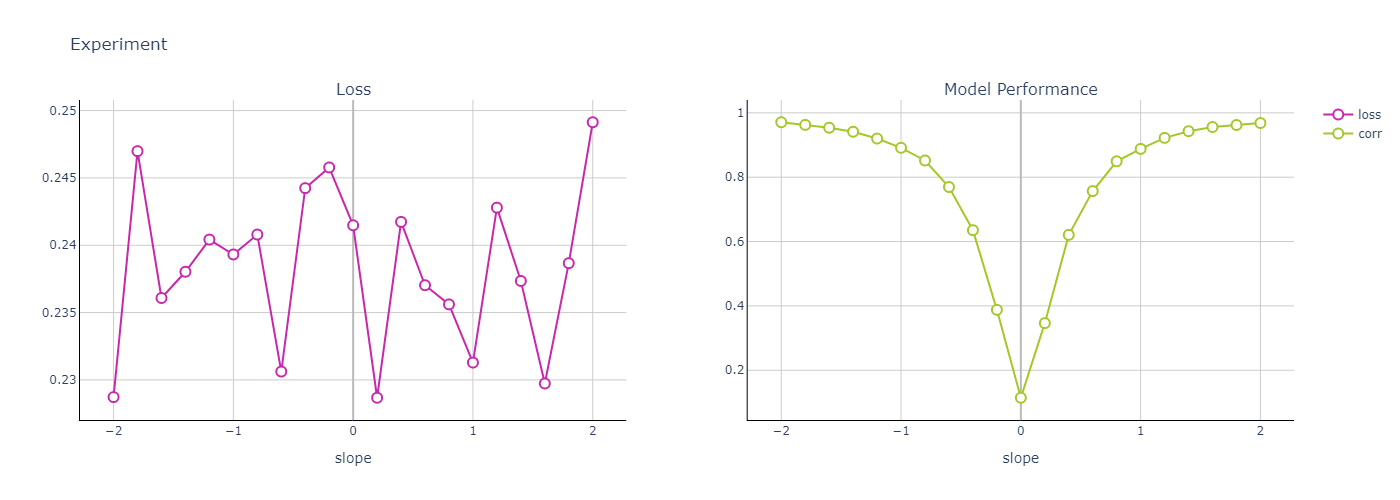

In [44]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Loss', 'Model Performance'])

fig.add_trace(go.Scatter(
    x=slopes, y=np.mean(results[:,:,0], axis=1),
    mode='markers+lines', marker=dict(color='white', size=10, line=dict(color='#c828ab', width=2)),
    line=dict(color='#c828ab'), name='loss'
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=slopes, y=np.mean(results[:,:,1], axis=1),
    mode='markers+lines', marker=dict(color='white', size=10, line=dict(color='#a3c828', width=2)),
    line=dict(color='#a3c828'), name='corr'
), row=1, col=2)

plotly_main_subplot_layout(fig, title='Experiment', x='slope')

When the slope is close to 0, the models performance decreases since x is less informative relative to y.

___
### X

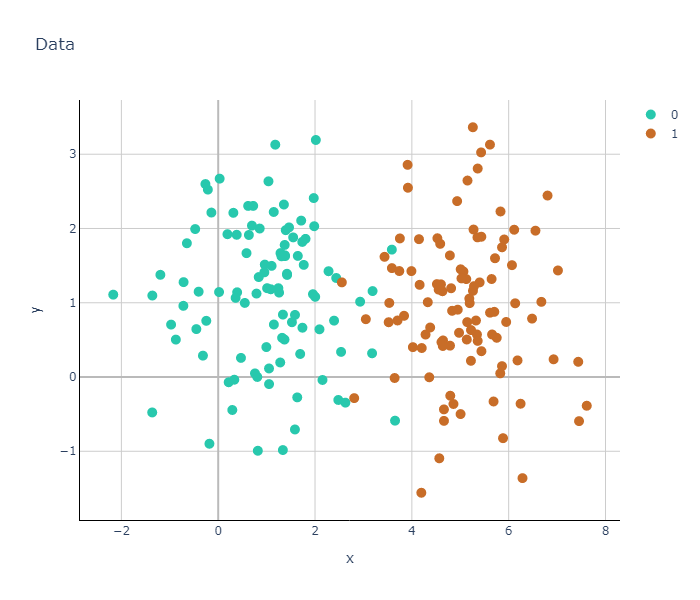

In [61]:
nPerClust = 100
blur = 1

A = [1, 1]
B = [5, 1]

# generate data
a = [A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur]
b = [B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

main_fig = go.Figure()
main_fig.add_trace(go.Scatter(
    x=data[np.where(labels==0)[0],0],
    y=data[np.where(labels==0)[0],1], name='0',
    mode='markers', marker=dict(color='#28c8ad', size=10)
))
main_fig.add_trace(go.Scatter(
    x=data[np.where(labels==1)[0],0],
    y=data[np.where(labels==1)[0],1], name='1',
    mode='markers', marker=dict(color='#c86d28', size=10)
))
plotly_main_layout(main_fig, title='Data')

In [72]:
ANNclassify = nn.Sequential(
    nn.Linear(2,1), # Input layer
    nn.ReLU(),      # Activation layer
    nn.Linear(1,1), # Output layer
    nn.Sigmoid(),   # Output activation layer
)

learningRate = 0.01
lossfun = nn.BCELoss()
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)

numepochs = 1000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

  yHat = ANNclassify(data)    # forward

  loss = lossfun(yHat,labels) # compute loss
  losses[epochi] = loss         

  optimizer.zero_grad()       # backpropagation
  loss.backward()
  optimizer.step()

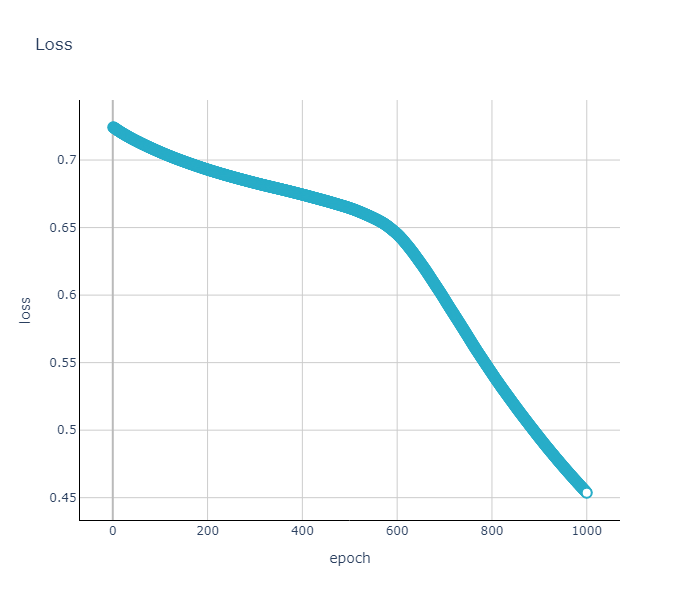

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[i+1 for i in range(numepochs)], y=losses.detach(), 
    name='loss', mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
))
plotly_main_layout(fig, x='epoch', y='loss', title='Loss')

In [74]:
predictions = ANNclassify(data)
predlabels = predictions > 0.5

misclassified = np.where(predlabels != labels)[0]

totalacc = 100-100*len(misclassified)/(2*nPerClust)
print('Final accuracy: %g%%' %totalacc)

Final accuracy: 95.5%


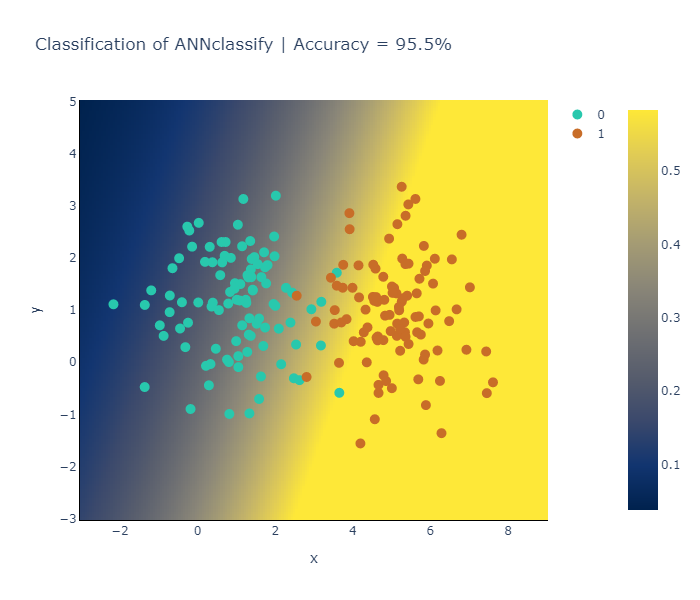

In [106]:
import torch
import numpy as np
import plotly.graph_objects as go

x = np.linspace(-3, 9, 200)
y = np.linspace(-3, 5, 150)
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]

with torch.no_grad():
    inputs = torch.tensor(grid, dtype=torch.float32)
    outputs = ANNclassify(inputs)
    predictions = (outputs).numpy().reshape(xx.shape)

fig = go.Figure(data=go.Heatmap(
    z=predictions, x=x, y=y,
    colorscale='cividis',
    colorbar=dict(title='Class'),
    showscale=True
))

fig.add_traces(main_fig['data'])
fig = plotly_main_layout(fig, title=f'Classification of ANNclassify | Accuracy = {totalacc}%')
fig['data'][0].colorbar = dict(x=1.15)
fig

___
### X

___
### X

___
### X

___
### X